## Identifiability Test of Linear VAE on Synthetic Dataset

In [148]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [149]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import ltcl
import numpy as np
from ltcl.datasets.sim_dataset import SimulationDataset
from ltcl.modules.lvae import AfflineVAESynthetic
import random
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [150]:
use_cuda = True
device = torch.device("cuda:0" if use_cuda else "cpu")

In [467]:
data = SimulationDataset()
num_validation_samples = 2500
train_data, val_data = random_split(data, [len(data)-num_validation_samples, num_validation_samples])
train_loader = DataLoader(train_data, batch_size=12800, shuffle=True, pin_memory=True, drop)
val_loader   = DataLoader(val_data, batch_size=16, shuffle=False, pin_memory=True)

### Warm start spline flow

In [ ]:
batch_size = 64
spline_optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.spline.parameters()), 
                                    lr=1e-3,
                                    weight_decay=0.0)
# Warm-start the prior to standard normal dist
for step in range(5000):
    latent_size = 4
#     y_t = torch.normal(0, 1, size=(batch_size, latent_size))
    y_t = torch.distributions.laplace.Laplace(0,1).rsample((batch_size, latent_size))
    dataset = y_t.to(device)
    spline_optimizer.zero_grad()
    z, logabsdet = model.spline(dataset)
    logp = model.spline.base_dist.log_prob(z) + logabsdet
    loss = -torch.mean(logp)
    loss.backward(retain_graph=True)
    spline_optimizer.step()
# This checkpoint will be loaded in lvae.py
torch.save(model.spline.state_dict(), "/home/cmu_wyao/spline.pth")

### Load model checkpoint

In [9]:
model = AfflineVAESynthetic(4,4,2).to(device)

/home/cmu_wyao/projects/ltcl/ltcl/modules/components/beta.py:166: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(m.weight)


In [592]:
model = model.load_from_checkpoint("/home/cmu_wyao/checkpoints/linear_vae/lightning_logs/version_52/checkpoints/epoch=13-step=108536.ckpt",
                                   input_dim = 4, z_dim=4, lag=2)

/home/cmu_wyao/projects/ltcl/ltcl/modules/components/beta.py:166: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(m.weight)


In [711]:
model.eval()

AfflineVAESynthetic(
  (net): BetaVAE_MLP(
    (encoder): Sequential(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): LeakyReLU(negative_slope=0.2)
      (4): Linear(in_features=128, out_features=128, bias=True)
      (5): LeakyReLU(negative_slope=0.2)
      (6): Linear(in_features=128, out_features=128, bias=True)
      (7): LeakyReLU(negative_slope=0.2)
      (8): Linear(in_features=128, out_features=8, bias=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): LeakyReLU(negative_slope=0.2)
      (4): Linear(in_features=128, out_features=128, bias=True)
      (5): LeakyReLU(negative_slope=0.2)
      (6): Linear(in_features=128, out_features=128, bias=True)
      (7): LeakyReLU(negative_slope=0.2)

In [593]:
model.to('cpu')

AfflineVAESynthetic(
  (net): BetaVAE_MLP(
    (encoder): Sequential(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): LeakyReLU(negative_slope=0.2)
      (4): Linear(in_features=128, out_features=128, bias=True)
      (5): LeakyReLU(negative_slope=0.2)
      (6): Linear(in_features=128, out_features=128, bias=True)
      (7): LeakyReLU(negative_slope=0.2)
      (8): Linear(in_features=128, out_features=8, bias=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): LeakyReLU(negative_slope=0.2)
      (4): Linear(in_features=128, out_features=128, bias=True)
      (5): LeakyReLU(negative_slope=0.2)
      (6): Linear(in_features=128, out_features=128, bias=True)
      (7): LeakyReLU(negative_slope=0.2)

### Compute permutation and sign flip

In [1282]:
for batch in train_loader:
    break
batch_size = batch['xt'].shape[0]

In [1283]:
x_recon, mu, logvar, z = model.forward(batch)
mu = mu.view(batch_size, -1, 4)
A = mu[:,0,:].detach().cpu().numpy()
B = batch['yt'][:,0,:].detach().cpu().numpy()
C = np.zeros((4,4))
for i in range(4):
    C[i] = -np.abs(np.corrcoef(B, A, rowvar=False)[i,4:])
from scipy.optimize import linear_sum_assignment
row_ind, col_ind = linear_sum_assignment(C)
A = A[:, col_ind]
mask = np.ones(4)
for i in range(4):
    if np.corrcoef(B, A, rowvar=False)[i,4:][i] > 0:
        mask[i] = -1
print("Permutation:",col_ind)
print("Sign Flip:", mask)

Permutation: [1 0 2 3]
Sign Flip: [ 1.  1. -1.  1.]


In [1284]:
# Permute column here
mu = mu[:,:,col_ind]
# Flip sign here
mu = mu * torch.Tensor(mask, device=mu.device).view(1,1,4)
mu = -mu

Text(0.5, 1.0, 'Current latent variable $z_t$')

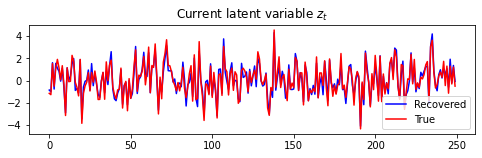

In [1294]:
fig = plt.figure(figsize=(8,2))
col = 0
plt.plot(mu[:250,-1,col].detach().cpu().numpy(), color='b', label='Recovered')
plt.plot(batch['yt_'].squeeze()[:250,col].detach().cpu().numpy(), color='r', label="True")
plt.legend()
plt.title("Current latent variable $z_t$")

Text(0.5, 1.0, 'Past latent variable $z_l$')

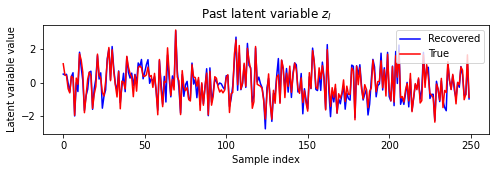

In [1295]:
fig = plt.figure(figsize=(8,2))
col = 3
l = 1
plt.plot(batch['yt'].squeeze()[:250,l,col].detach().cpu().numpy(), color='b', label='Recovered')
plt.plot(mu[:,:-1,:][:250,l,col].detach().cpu().numpy(), color='r', label="True")
plt.xlabel("Sample index")
plt.ylabel("Latent variable value")
plt.legend()
plt.title("Past latent variable $z_l$")

/home/cmu_wyao/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Learned noise prior by spline flow')

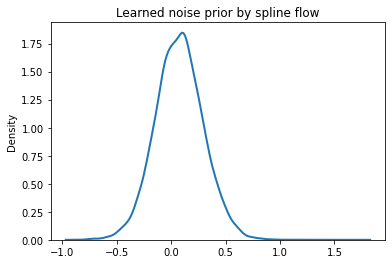

In [1305]:
eps = model.sample(batch["xt"].cpu())
eps = eps.detach().cpu().numpy()
component_idx = 3
sns.distplot(eps[:,component_idx], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2});
plt.title("Learned noise prior by spline flow")

### System identification (causal discovery)

In [1276]:
from ltcl.modules.components.base import GroupLinearLayer
trans_func = GroupLinearLayer(din = 4, 
                              dout = 4,
                              num_blocks = 2,
                              diagonal = False)
opt = torch.optim.Adam(trans_func.parameters(),lr=0.01)
lossfunc = torch.nn.L1Loss()

In [1278]:
max_iters = 2
for step in range(max_iters):
    for batch in train_loader:
        batch_size = batch['yt'].shape[0]
        x_recon, mu, logvar, z = model.forward(batch)
        mu = mu.view(batch_size, -1, 4)
        # Fix permutation before training
        mu = mu[:,:,col_ind]
        # Fix sign flip before training
        mu = mu * torch.Tensor(mask, device=mu.device).view(1,1,4)
        mu = -mu
        pred = trans_func(mu[:,:-1,:]).sum(dim=1)
        true = mu[:,-1,:]
        loss = lossfunc(pred, true) #+ torch.mean(adaptive.lossfun((pred - true)))

        opt.zero_grad()
        loss.backward()
        opt.step()
        print(loss.item())

1.0938305854797363
1.0746357440948486
1.057559609413147
1.04140305519104
1.0256447792053223
0.9966999888420105
0.9840753674507141
0.9624587893486023
0.9382084012031555
0.9258038401603699
0.9045463800430298
0.888541579246521
0.8723204731941223
0.8446354866027832
0.8338860869407654
0.817707359790802
0.801297664642334
0.7806022763252258
0.7668846249580383
0.7447891235351562
0.7261824607849121
0.7123792767524719
0.7016515135765076
0.6779553294181824
0.6603946089744568
0.6465804576873779
0.62699294090271
0.6115681529045105
0.5954993367195129
0.5790026187896729
0.5641351938247681
0.5474576950073242
0.5290529131889343
0.5170286297798157
0.4999503791332245
0.48265570402145386
0.46985068917274475
0.4551510512828827
0.43808531761169434
0.4244050085544586
0.41062355041503906
0.39353999495506287
0.3821968138217926
0.3675312101840973
0.3536105453968048
0.3395749032497406
0.3257830739021301
0.3129243850708008
0.300412654876709
0.28841954469680786
0.2744472026824951
0.2615981996059418
0.2494435459375

In [1307]:
B2 = trans_func.w[0].detach().cpu().numpy()
B1 = trans_func.w[1].detach().cpu().numpy()
BB2 = np.load("/home/cmu_wyao/projects/data/linear_nongaussian/W2.npy")
BB1 = np.load("/home/cmu_wyao/projects/data/linear_nongaussian/W1.npy")

In [1308]:
b = np.concatenate((B1,B2), axis=0)
bb = np.concatenate((BB1,BB2), axis=0)
b = b / np.linalg.norm(b, axis=0).reshape(1, -1)
bb = bb / np.linalg.norm(bb, axis=0).reshape(1, -1)
pred = (b / np.linalg.norm(b, axis=0).reshape(1, -1)).reshape(-1)
true = (bb / np.linalg.norm(bb, axis=0).reshape(1, -1)).reshape(-1)

Text(0, 0.5, 'Ground truth weight')

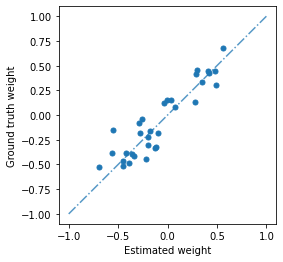

In [1309]:
fig, ax = plt.subplots()
ax.scatter(pred, true, s=25, cmap=plt.cm.coolwarm, zorder=10)
lims = [-1,1
]

# now plot both limits against eachother
ax.plot(lims, lims, '-.', alpha=0.75, zorder=0)
ax.set_aspect('equal')
# ax.set_xlim(lims)
# ax.set_ylim(lims)
ax.set_xlabel("Estimated weight")
ax.set_ylabel("Ground truth weight")

In [1310]:
def amari_distance(r):
    p = r.shape[0]
    abs_r = np.abs(r)
    l = np.sum(np.sum(abs_r, axis=1, keepdims=True) / np.max(abs_r, axis=1, keepdims=True) - 1, axis=0)
    r = np.sum(np.sum(abs_r, axis=0, keepdims=True) / np.max(abs_r, axis=0, keepdims=True) - 1, axis=1)
    return 1/(2*p*(p-1)) * (l+r)

In [1311]:
am2 = amari_distance(np.linalg.inv(B2) @ BB2)
am1 = amari_distance(np.linalg.inv(B1) @ BB1)
print(f"Amari index: {am2[0], am1[0]}")

Amari index: (0.32262991381399375, 0.28428614209277603)


In [354]:
from sklearn.metrics import r2_score
r2_score(pred,true)

0.0204760846757035